# Import library

In [ ]:
import pandas as pd
import numpy as np
import random
import datetime
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import mlflow
import os

print("Libraries imported successfully!")

Libraries imported successfully!


# Dataset Configuration

In [ ]:
# Load the datasets
try:
    df_mk = pd.read_csv('./mk_dsi.csv')
    df_ruang = pd.read_csv('./ruang_kuliah.csv')

    # Rename columns for consistency and to remove spaces
    df_mk.columns = ['kode_mk', 'nama_mk', 'prodi', 'prioritas', 'berminat', 'dosen_id']
    df_ruang.columns = ['kode_ruang', 'lokasi', 'lantai', 'keterangan']

    # Clean data and ensure correct data types
    df_mk['dosen_id'] = df_mk['dosen_id'].fillna('Belum Ada Dosen').astype(str)

except FileNotFoundError:
    print("--- FAILED TO LOAD FILES ---")
    print("Ensure 'mk_dsi.csv' and 'ruang_kuliah.csv' are in the same directory as this notebook.")
    df_mk, df_ruang = pd.DataFrame(), pd.DataFrame() # Create empty dataframes on failure

# Check if dataframes loaded successfully before proceeding
if not df_mk.empty:
    # --- MAIN CHANGE: Treat each row as a unique item ---
    list_of_courses_to_schedule = df_mk.to_dict('records')

    # Adjust data structure for compatibility with the rest of the code.
    # The fitness function expects 'dosen_list', so create a list containing
    # the single lecturer for each course row.
    for course in list_of_courses_to_schedule:
        # The lecturer ID already exists, just wrap it in a list.
        course['dosen_list'] = [course['dosen_id']]

    list_ruang = df_ruang['kode_ruang'].unique().tolist()

    print("Data loading and pre-processing successful (each row treated as unique).")
    print(f"Total course items to schedule: {len(list_of_courses_to_schedule)}")
    print(f"Total Available Rooms: {len(list_ruang)}")
else:
    print("\nDataFrames are empty due to file loading failure. Subsequent cells will likely fail.")
    # Initialize variables to prevent errors in the next cell
    list_of_courses_to_schedule = []
    list_ruang = []
    df_ruang = pd.DataFrame() # Ensure df_ruang is defined even on failure

Pemuatan dan pra-pemrosesan data berhasil.
Total Mata Kuliah Unik yang akan dijadwalkan: 137
Total Ruangan Tersedia: 44


# Define Time Slot & Rooms

In [ ]:
# --- Time Slot Definition ---
def generate_time_slots():
    slots = []
    days = {"Senin": 0, "Selasa": 1, "Rabu": 2, "Kamis": 3, "Jumat": 4}

    for day_name, day_index in days.items():
        start_time = datetime.datetime.strptime("07:00", "%H:%M")
        end_time = datetime.datetime.strptime("18:00", "%H:%M")

        if day_name in ["Senin", "Selasa", "Rabu", "Kamis"]:
            break_start = datetime.datetime.strptime("12:10", "%H:%M")
            break_end = datetime.datetime.strptime("12:30", "%H:%M")
        else: # Friday
            break_start = datetime.datetime.strptime("11:15", "%H:%M")
            break_end = datetime.datetime.strptime("12:30", "%H:%M")

        current_time = start_time
        while current_time < end_time:
            slot_end_time = current_time + datetime.timedelta(minutes=50)
            # Check if the slot is outside the break time
            if not (current_time >= break_start and current_time < break_end):
                 slots.append(f"{day_name}_{current_time.strftime('%H:%M')}-{slot_end_time.strftime('%H:%M')}")
            current_time = slot_end_time

    # Add special slot for non-islamic religion courses on Friday
    special_break_start = datetime.datetime.strptime("11:15", "%H:%M")
    special_slot_end = special_break_start + datetime.timedelta(minutes=50)
    slots.append(f"Jumat_{special_break_start.strftime('%H:%M')}-{special_slot_end.strftime('%H:%M')}_AGAMA_KHUSUS")

    return slots

time_slots = generate_time_slots()

# --- Room Definitions ---
# Ensure df_ruang is not empty and has the required columns
if not df_ruang.empty and 'keterangan' in df_ruang.columns and 'kode_ruang' in df_ruang.columns:
    ruang_lab = [r['kode_ruang'] for i, r in df_ruang.iterrows() if isinstance(r.get('keterangan'), str) and 'lab' in r['keterangan'].lower()]
    # Use list_ruang which was defined in the previous cell
    ruang_reguler = [r for r in list_ruang if r not in ruang_lab]
else:
    ruang_lab = []
    ruang_reguler = []
    print("WARNING: DataFrame df_ruang is empty or missing required columns ('keterangan', 'kode_ruang'). Room definitions may be inaccurate.")


# Mark courses that require a lab, now iterating through list_of_courses_to_schedule
# Ensure list_of_courses_to_schedule is not empty
if list_of_courses_to_schedule:
    for course in list_of_courses_to_schedule:
        # Check if 'nama_mk' exists and is a string before checking for 'praktikum'
        if isinstance(course.get('nama_mk'), str) and 'praktikum' in course['nama_mk'].lower():
            course['jenis'] = 'lab'
        else:
            course['jenis'] = 'reguler'
else:
    print("WARNING: list_of_courses_to_schedule is empty. Marking course types skipped.")


print(f"Total Available Time Slots: {len(time_slots)}")
print(f"Total Regular Rooms: {len(ruang_reguler)}, Total Lab Rooms: {len(ruang_lab)}")

Total Slot Waktu Tersedia: 70
Total Ruang Reguler: 44, Total Ruang Lab: 0


# Function to Evaluate

In [ ]:
HARD_CONSTRAINT_PENALTY = 100
SOFT_CONSTRAINT_PENALTY = 1

def calculate_fitness(schedule, df_ruang_details, time_slots_list):
    """Calculates the fitness score for a single schedule (solution). Lower is better."""
    hard_violations = 0
    soft_score = 0

    room_time_usage = defaultdict(int)
    dosen_time_usage = defaultdict(list)

    # Iterating through each course allocation in the schedule
    for slot in schedule:
        # Hard Constraint #1: Room and Time Conflict
        room_time_key = (slot.get('ruang', 'N/A'), slot.get('waktu', 'N/A')) # Use .get for safety
        room_time_usage[room_time_key] += 1
        if room_time_usage[room_time_key] > 1:
            hard_violations += 1

        # Hard Constraint #2 & #3: Lecturer Conflict
        # Ensure 'dosen_list' exists and is iterable
        dosen_list = slot.get('dosen_list', [])
        current_time_slot = slot.get('waktu', 'N/A')
        if isinstance(dosen_list, list):
             for dosen in dosen_list:
                if dosen in dosen_time_usage[current_time_slot]:
                    hard_violations += 1
                dosen_time_usage[current_time_slot].append(dosen)
        else:
             # Handle case where dosen_list might not be a list as expected
             print(f"Warning: 'dosen_list' for course {slot.get('kode_mk')} is not a list: {dosen_list}")


    # Soft Constraint #1: Course Priority
    # Use .get with a default value (e.g., a high priority number if missing)
    total_priority = sum(s.get('prioritas', 10) for s in schedule) # Assume 10 if priority is missing
    soft_score += total_priority

    # Soft Constraint #2: Lecturer Movement
    dosen_schedule = defaultdict(list)
    for s in schedule:
        dosen_list = s.get('dosen_list', [])
        if isinstance(dosen_list, list):
            for dosen in dosen_list:
                 dosen_schedule[dosen].append({'waktu': s.get('waktu'), 'ruang': s.get('ruang')})

    # Ensure df_ruang_details is not empty before proceeding
    if not df_ruang_details.empty:
        for dosen, movements in dosen_schedule.items():
            if len(movements) > 1:
                # Filter out entries with missing 'waktu' before sorting
                valid_movements = [m for m in movements if m['waktu'] is not None and m['waktu'] in time_slots_list]
                if len(valid_movements) > 1:
                    try:
                        sorted_movements = sorted(valid_movements, key=lambda x: time_slots_list.index(x['waktu']))
                        for i in range(len(sorted_movements) - 1):
                             # Check if schedules are consecutive
                             if time_slots_list.index(sorted_movements[i+1]['waktu']) == time_slots_list.index(sorted_movements[i]['waktu']) + 1:
                                try:
                                    lantai_1 = df_ruang_details[df_ruang_details['kode_ruang'] == sorted_movements[i]['ruang']]['lantai'].iloc[0]
                                    lantai_2 = df_ruang_details[df_ruang_details['kode_ruang'] == sorted_movements[i+1]['ruang']]['lantai'].iloc[0]
                                    perbedaan_lantai = abs(lantai_1 - lantai_2)
                                    if perbedaan_lantai > 1:
                                        soft_score += perbedaan_lantai * SOFT_CONSTRAINT_PENALTY
                                except (IndexError, KeyError):
                                    # Handle cases where room code might not be found or floor data is missing
                                    # print(f"Warning: Could not find floor info for room {sorted_movements[i]['ruang']} or {sorted_movements[i+1]['ruang']}")
                                    continue
                    except ValueError as e:
                        # Handle cases where a time slot from the schedule might not be in the canonical time_slots_list
                        # print(f"Warning: Error sorting movements for lecturer {dosen}. Invalid time slot? Error: {e}")
                        continue # Skip this lecturer if sorting fails
    else:
        print("Warning: df_ruang_details is empty. Lecturer movement penalty calculation skipped.")


    return (hard_violations * HARD_CONSTRAINT_PENALTY) + soft_score, hard_violations

# Helper function to create a random schedule
def create_random_schedule(courses, rooms_reg, rooms_lab, times):
    schedule = []
    # Ensure rooms_reg, rooms_lab, and times are not empty
    if not rooms_reg: rooms_reg = ["DEFAULT_REG_ROOM"] # Provide fallback
    if not rooms_lab: rooms_lab = ["DEFAULT_LAB_ROOM"] # Provide fallback
    if not times: times = ["DEFAULT_TIME"] # Provide fallback

    for course in courses:
        slot = copy.deepcopy(course)
        # Use .get for safety, check if rooms exist
        course_type = course.get('jenis', 'reguler')
        if course_type == 'lab':
             slot['ruang'] = random.choice(rooms_lab) if rooms_lab else "DEFAULT_LAB_ROOM"
        else:
             slot['ruang'] = random.choice(rooms_reg) if rooms_reg else "DEFAULT_REG_ROOM"

        slot['waktu'] = random.choice(times) if times else "DEFAULT_TIME"
        schedule.append(slot)
    return schedule

# Setup MLFlow

In [ ]:
# Set the experiment name for MLflow. If it doesn't exist, MLflow will create it.
mlflow.set_experiment("UCTP Optimization Comparison")
print("MLflow experiment set to 'UCTP Optimization Comparison'")

2025/10/22 07:56:37 INFO mlflow.tracking.fluent: Experiment with name 'UCTP Optimization Comparison' does not exist. Creating a new experiment.


MLflow experiment set to 'UCTP Optimization Comparison'


# Implementing PSO

In [10]:
class Particle:
    def __init__(self, courses, rooms_reg, rooms_lab, times):
        self.position = create_random_schedule(courses, rooms_reg, rooms_lab, times)
        self.best_position = copy.deepcopy(self.position)
        self.fitness, self.violations = float('inf'), float('inf')
        self.best_fitness = float('inf')

def pso_optimizer_mlflow(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                         n_particles, n_iterations, w, c1, c2):
    
    swarm = [Particle(courses, rooms_reg, rooms_lab, times) for _ in range(n_particles)]
    global_best_position = None
    global_best_fitness = float('inf')
    fitness_history = []

    for i in range(n_iterations):
        for particle in swarm:
            particle.fitness, particle.violations = calculate_fitness(particle.position, df_ruang_details, time_slots_list)
            
            if particle.fitness < particle.best_fitness:
                particle.best_fitness = particle.fitness
                particle.best_position = copy.deepcopy(particle.position)
            
            if particle.fitness < global_best_fitness:
                global_best_fitness = particle.fitness
                global_best_position = copy.deepcopy(particle.position)

        for particle in swarm:
            new_position = copy.deepcopy(particle.position)
            for j in range(len(courses)):
                if random.random() < c1:
                    new_position[j]['ruang'] = particle.best_position[j]['ruang']
                    new_position[j]['waktu'] = particle.best_position[j]['waktu']
                
                if random.random() < c2:
                    new_position[j]['ruang'] = global_best_position[j]['ruang']
                    new_position[j]['waktu'] = global_best_position[j]['waktu']
            
            particle.position = new_position
        
        fitness_history.append(global_best_fitness)
        # Log metric at each iteration
        mlflow.log_metric("best_fitness_per_iteration", global_best_fitness, step=i)
        print(f"PSO Iteration {i+1}/{n_iterations} | Best Fitness: {global_best_fitness}")
        
    final_fitness, final_violations = calculate_fitness(global_best_position, df_ruang_details, time_slots_list)
    return global_best_position, final_fitness, final_violations, fitness_history

# Run the PSO Algorithm

In [11]:
# --- Execute and Log PSO ---
print("\n--- Running Particle Swarm Optimization with MLflow Logging ---")
pso_params = {
    "n_particles": 50,
    "n_iterations": 100,
    "w": 0.5,
    "c1": 1.5,
    "c2": 1.5
}

with mlflow.start_run(run_name="PSO_Run") as run:
    # Log parameters
    mlflow.log_params(pso_params)
    
    pso_best_schedule, pso_fitness, pso_violations, pso_history = pso_optimizer_mlflow(
        list_mk_unique, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots, **pso_params
    )
    
    # Log final metrics
    mlflow.log_metric("final_best_fitness", pso_fitness)
    mlflow.log_metric("final_hard_violations", pso_violations)
    
    # Save schedule to CSV and log as an artifact
    pso_csv_path = "jadwal_pso.csv"
    pd.DataFrame(pso_best_schedule).to_csv(pso_csv_path, index=False)
    mlflow.log_artifact(pso_csv_path, "schedules")
    os.remove(pso_csv_path) # Clean up file

print("\n--- PSO Run Finished ---")
print(f"Final Best Fitness: {pso_fitness}")
print(f"Final Hard Constraint Violations: {pso_violations}")


--- Running Particle Swarm Optimization with MLflow Logging ---
PSO Iteration 1/100 | Best Fitness: 20255
PSO Iteration 2/100 | Best Fitness: 20255
PSO Iteration 3/100 | Best Fitness: 20255
PSO Iteration 4/100 | Best Fitness: 20255
PSO Iteration 5/100 | Best Fitness: 20255
PSO Iteration 6/100 | Best Fitness: 20255
PSO Iteration 7/100 | Best Fitness: 20255
PSO Iteration 8/100 | Best Fitness: 20255
PSO Iteration 9/100 | Best Fitness: 20255
PSO Iteration 10/100 | Best Fitness: 20255
PSO Iteration 11/100 | Best Fitness: 20255
PSO Iteration 12/100 | Best Fitness: 20255
PSO Iteration 13/100 | Best Fitness: 20255
PSO Iteration 14/100 | Best Fitness: 20255
PSO Iteration 15/100 | Best Fitness: 20255
PSO Iteration 16/100 | Best Fitness: 20255
PSO Iteration 17/100 | Best Fitness: 20255
PSO Iteration 18/100 | Best Fitness: 20255
PSO Iteration 19/100 | Best Fitness: 20255
PSO Iteration 20/100 | Best Fitness: 20255
PSO Iteration 21/100 | Best Fitness: 20255
PSO Iteration 22/100 | Best Fitness: 2025

# Implementing Ant Colony Optimization (ACO)

In [ ]:
def aco_optimizer_mlflow(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                         n_ants, n_iterations, alpha, beta, evaporation_rate):

    if not courses:
        print("ACO Warning: No courses to schedule.")
        return [], float('inf'), float('inf'), []

    pheromones = defaultdict(lambda: 1.0)
    best_schedule_overall = None
    best_fitness_overall = float('inf')
    best_violations_overall = float('inf')
    fitness_history = []

    num_courses = len(courses)

    for i in range(n_iterations):
        schedules = []
        for ant in range(n_ants):
            schedule = []
            available_courses_idx = list(range(num_courses))
            random.shuffle(available_courses_idx)

            current_schedule_state = {} # To check constraints during construction (optional, complex)

            for course_idx in available_courses_idx:
                course = courses[course_idx]
                choices = []
                possible_rooms = rooms_lab if course.get('jenis') == 'lab' else rooms_reg
                if not possible_rooms: # Fallback if no rooms of the required type exist
                    possible_rooms = rooms_reg if course.get('jenis') != 'lab' else rooms_lab
                    if not possible_rooms: possible_rooms = ["DEFAULT_ROOM"]


                for room in possible_rooms:
                    for time in times:
                        heuristic = random.random() # Simple heuristic, can be improved
                        pheromone_level = pheromones[(course.get('kode_mk', course_idx), room, time)] # Use index if kode_mk missing
                        prob = (pheromone_level ** alpha) * (heuristic ** beta)
                        choices.append({'prob': prob, 'room': room, 'time': time})

                total_prob = sum(c['prob'] for c in choices) if choices else 0
                if total_prob == 0 or not choices:
                    chosen_room = random.choice(possible_rooms)
                    chosen_time = random.choice(times) if times else "DEFAULT_TIME"
                else:
                    r = random.uniform(0, total_prob)
                    upto = 0
                    chosen_room, chosen_time = choices[0]['room'], choices[0]['time'] # Default choice
                    for c in choices:
                        if upto + c['prob'] >= r:
                            chosen_room = c['room']
                            chosen_time = c['time']
                            break
                        upto += c['prob']

                slot = copy.deepcopy(course)
                slot['ruang'] = chosen_room
                slot['waktu'] = chosen_time
                schedule.append(slot)
                # Update current_schedule_state (optional)

            schedules.append(schedule)

        # Evaporate pheromones
        for key in list(pheromones.keys()): # Iterate over keys copy
            pheromones[key] *= (1 - evaporation_rate)
            # Optional: Remove pheromones below a threshold

        # Deposit pheromones
        best_schedule_iter = None
        best_fitness_iter = float('inf')
        best_violations_iter = float('inf')
        for schedule in schedules:
             if not schedule: continue # Skip empty schedules
             fitness, violations = calculate_fitness(schedule, df_ruang_details, time_slots_list)
             if fitness < best_fitness_iter:
                best_fitness_iter = fitness
                best_violations_iter = violations
                best_schedule_iter = schedule

             # Deposit based on quality (only for valid schedules)
             if fitness != float('inf'):
                 deposit_amount = 1.0 / (1.0 + fitness) # More deposit for better fitness
                 for slot in schedule:
                     pheromones[(slot.get('kode_mk', schedule.index(slot)), slot.get('ruang'), slot.get('waktu'))] += deposit_amount


        if best_fitness_iter < best_fitness_overall:
            best_fitness_overall = best_fitness_iter
            best_violations_overall = best_violations_iter
            best_schedule_overall = best_schedule_iter

        fitness_history.append(best_fitness_overall)
        # Log metric at each iteration
        mlflow.log_metric("best_fitness_per_iteration", best_fitness_overall, step=i)
        print(f"ACO Iteration {i+1}/{n_iterations} | Best Fitness: {best_fitness_overall} | Violations: {best_violations_overall}")

    # Handle case where no valid schedule was found
    if best_schedule_overall is None and schedules:
         # Fallback: calculate fitness for all generated schedules and pick best
         valid_schedules_fitness = []
         for s in schedules:
             if s:
                 fit, viol = calculate_fitness(s, df_ruang_details, time_slots_list)
                 if fit != float('inf'):
                     valid_schedules_fitness.append({'schedule': s, 'fitness': fit, 'violations': viol})
         if valid_schedules_fitness:
             best_fallback = min(valid_schedules_fitness, key=lambda x: x['fitness'])
             best_schedule_overall = best_fallback['schedule']
             best_fitness_overall = best_fallback['fitness']
             best_violations_overall = best_fallback['violations']
         else:
              return [], float('inf'), float('inf'), fitness_history # No valid schedule found at all

    final_fitness, final_violations = calculate_fitness(best_schedule_overall, df_ruang_details, time_slots_list) if best_schedule_overall else (float('inf'), float('inf'))

    return best_schedule_overall if best_schedule_overall else [], final_fitness, final_violations, fitness_history

# Run the ACO Algorithm

In [ ]:
# --- Execute and Log ACO ---
print("\n--- Running Ant Colony Optimization with MLflow Logging ---")
aco_params = {
    "n_ants": 20,
    "n_iterations": 100,
    "alpha": 1.0,
    "beta": 2.0,
    "evaporation_rate": 0.5
}

if list_of_courses_to_schedule:
    with mlflow.start_run(run_name="ACO_Run") as run:
        # Log parameters
        mlflow.log_params(aco_params)

        aco_best_schedule, aco_fitness, aco_violations, aco_history = aco_optimizer_mlflow(
            list_of_courses_to_schedule, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots, **aco_params
        )

        # Log final metrics
        mlflow.log_metric("final_best_fitness", aco_fitness)
        mlflow.log_metric("final_hard_violations", aco_violations)

        # Save schedule to CSV and log as an artifact
        if aco_best_schedule:
            aco_csv_path = "jadwal_aco.csv"
            try:
                pd.DataFrame(aco_best_schedule).to_csv(aco_csv_path, index=False)
                mlflow.log_artifact(aco_csv_path, "schedules")
                os.remove(aco_csv_path)
            except Exception as e:
                print(f"Error saving or logging ACO schedule: {e}")
        else:
            print("No valid ACO schedule found to save.")


    print("\n--- ACO Run Finished ---")
    print(f"Final Best Fitness: {aco_fitness}")
    print(f"Final Hard Constraint Violations: {aco_violations}")
else:
    print("Skipping ACO execution because course data is empty.")
    aco_best_schedule, aco_fitness, aco_violations, aco_history = [], float('inf'), float('inf'), []


--- Menjalankan Ant Colony Optimization ---
ACO Iteration 1/30 | Best Fitness: 21051
ACO Iteration 2/30 | Best Fitness: 20781
ACO Iteration 3/30 | Best Fitness: 20781
ACO Iteration 4/30 | Best Fitness: 20501
ACO Iteration 5/30 | Best Fitness: 20501
ACO Iteration 6/30 | Best Fitness: 20498
ACO Iteration 7/30 | Best Fitness: 20498
ACO Iteration 8/30 | Best Fitness: 20498
ACO Iteration 9/30 | Best Fitness: 20498
ACO Iteration 10/30 | Best Fitness: 20498
ACO Iteration 11/30 | Best Fitness: 20305
ACO Iteration 12/30 | Best Fitness: 19983
ACO Iteration 13/30 | Best Fitness: 19983
ACO Iteration 14/30 | Best Fitness: 19983
ACO Iteration 15/30 | Best Fitness: 19983
ACO Iteration 16/30 | Best Fitness: 19983
ACO Iteration 17/30 | Best Fitness: 19983
ACO Iteration 18/30 | Best Fitness: 19983
ACO Iteration 19/30 | Best Fitness: 19983
ACO Iteration 20/30 | Best Fitness: 19983
ACO Iteration 21/30 | Best Fitness: 19983
ACO Iteration 22/30 | Best Fitness: 19983
ACO Iteration 23/30 | Best Fitness: 1998

# Implementing Artificial Bee Colony

In [ ]:
class FoodSource:
    def __init__(self, courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list):
        if courses:
            self.solution = create_random_schedule(courses, rooms_reg, rooms_lab, times)
            self.fitness, self.violations = calculate_fitness(self.solution, df_ruang_details, time_slots_list)
        else:
            self.solution = []
            self.fitness, self.violations = float('inf'), float('inf')
        self.trials = 0

def abc_optimizer_mlflow(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                         n_bees, n_iterations, limit):

    if not courses:
        print("ABC Warning: No courses to schedule.")
        return [], float('inf'), float('inf'), []

    num_courses = len(courses)
    colony = [FoodSource(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list) for _ in range(n_bees)]
    best_solution_overall = None
    best_fitness_overall = float('inf')
    best_violations_overall = float('inf')
    fitness_history = []

    for i in range(n_iterations):
        # Employed Bee Phase
        for j in range(n_bees):
            if not colony[j].solution: continue # Skip if no solution

            # Create neighbor solution by modifying one random assignment
            k = random.randint(0, num_courses - 1)
            neighbor_solution = copy.deepcopy(colony[j].solution)

            # Ensure neighbor_solution has the element k
            if k < len(neighbor_solution):
                course_to_change = neighbor_solution[k]
                original_course_info = courses[k] # Get original info for type check

                possible_rooms = rooms_lab if original_course_info.get('jenis') == 'lab' else rooms_reg
                if not possible_rooms: possible_rooms = ["DEFAULT_ROOM"] # Fallback

                course_to_change['ruang'] = random.choice(possible_rooms)
                course_to_change['waktu'] = random.choice(times) if times else "DEFAULT_TIME"

                neighbor_fitness, _ = calculate_fitness(neighbor_solution, df_ruang_details, time_slots_list)

                if neighbor_fitness < colony[j].fitness:
                    colony[j].solution = neighbor_solution
                    colony[j].fitness = neighbor_fitness
                    colony[j].trials = 0
                else:
                    colony[j].trials += 1
            else:
                 # This case should ideally not happen if initialization is correct
                 colony[j].trials += 1


        # Calculate probabilities for Onlooker Bees
        fitness_values = [fs.fitness for fs in colony if fs.solution]
        if not fitness_values: continue # Skip if no valid solutions

        max_fitness = max(fitness_values) if fitness_values else 1 # Avoid division by zero if all inf
        probabilities = []
        total_prob_fitness = 0
        for fs in colony:
             if fs.solution:
                 # Normalize fitness for probability calculation (higher fitness -> lower prob)
                 # Avoid infinity issues
                 prob_fitness = 1.0 / (1.0 + fs.fitness) if fs.fitness != float('inf') else 0
                 probabilities.append(prob_fitness)
                 total_prob_fitness += prob_fitness
             else:
                 probabilities.append(0)

        if total_prob_fitness == 0: total_prob_fitness = 1 # Avoid division by zero


        # Onlooker Bee Phase
        for j in range(n_bees):
            # Select food source based on probability
            selected_source_idx = -1
            if total_prob_fitness > 0:
                 r = random.uniform(0, 1) # Use normalized probability
                 upto = 0
                 for k, prob in enumerate(probabilities):
                     upto += (prob / total_prob_fitness)
                     if upto >= r:
                         selected_source_idx = k
                         break
            if selected_source_idx == -1: selected_source_idx = random.randrange(n_bees) # Fallback

            if not colony[selected_source_idx].solution: continue # Skip if selected source is invalid

            # Create neighbor solution (same logic as employed bee)
            k = random.randint(0, num_courses - 1)
            neighbor_solution = copy.deepcopy(colony[selected_source_idx].solution)

            if k < len(neighbor_solution):
                course_to_change = neighbor_solution[k]
                original_course_info = courses[k]

                possible_rooms = rooms_lab if original_course_info.get('jenis') == 'lab' else rooms_reg
                if not possible_rooms: possible_rooms = ["DEFAULT_ROOM"]

                course_to_change['ruang'] = random.choice(possible_rooms)
                course_to_change['waktu'] = random.choice(times) if times else "DEFAULT_TIME"

                neighbor_fitness, _ = calculate_fitness(neighbor_solution, df_ruang_details, time_slots_list)

                if neighbor_fitness < colony[selected_source_idx].fitness:
                    colony[selected_source_idx].solution = neighbor_solution
                    colony[selected_source_idx].fitness = neighbor_fitness
                    colony[selected_source_idx].trials = 0
                else:
                    colony[selected_source_idx].trials += 1
            else:
                 colony[selected_source_idx].trials += 1

        # Scout Bee Phase
        for j in range(n_bees):
            if colony[j].trials > limit:
                # Replace the exhausted food source with a new random one
                colony[j] = FoodSource(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list)

        # Update overall best solution
        current_best = min(colony, key=lambda fs: fs.fitness if fs.solution else float('inf'))
        if current_best.solution and current_best.fitness < best_fitness_overall:
            best_fitness_overall = current_best.fitness
            best_violations_overall = current_best.violations
            best_solution_overall = current_best.solution

        fitness_history.append(best_fitness_overall)
        # Log metric at each iteration
        mlflow.log_metric("best_fitness_per_iteration", best_fitness_overall, step=i)
        print(f"ABC Iteration {i+1}/{n_iterations} | Best Fitness: {best_fitness_overall} | Violations: {best_violations_overall}")

     # Final check in case the best solution was never updated properly
    if best_solution_overall is None and colony:
         valid_colonies = [fs for fs in colony if fs.solution and fs.fitness != float('inf')]
         if valid_colonies:
             best_fallback = min(valid_colonies, key=lambda fs: fs.fitness)
             best_solution_overall = best_fallback.solution
             best_fitness_overall = best_fallback.fitness
             best_violations_overall = best_fallback.violations
         else:
             return [], float('inf'), float('inf'), fitness_history


    final_fitness, final_violations = calculate_fitness(best_solution_overall, df_ruang_details, time_slots_list) if best_solution_overall else (float('inf'), float('inf'))

    return best_solution_overall if best_solution_overall else [], final_fitness, final_violations, fitness_history



# Run the ABC Algorithm

In [ ]:
# --- Execute and Log ABC ---
print("\n--- Running Artificial Bee Colony Optimization with MLflow Logging ---")
abc_params = {
    "n_bees": 50,
    "n_iterations": 100,
    "limit": 20
}

if list_of_courses_to_schedule:
    with mlflow.start_run(run_name="ABC_Run") as run:
        # Log parameters
        mlflow.log_params(abc_params)

        abc_best_schedule, abc_fitness, abc_violations, abc_history = abc_optimizer_mlflow(
            list_of_courses_to_schedule, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots, **abc_params
        )

        # Log final metrics
        mlflow.log_metric("final_best_fitness", abc_fitness)
        mlflow.log_metric("final_hard_violations", abc_violations)

        # Save schedule to CSV and log as an artifact
        if abc_best_schedule:
            abc_csv_path = "jadwal_abc.csv"
            try:
                pd.DataFrame(abc_best_schedule).to_csv(abc_csv_path, index=False)
                mlflow.log_artifact(abc_csv_path, "schedules")
                os.remove(abc_csv_path)
            except Exception as e:
                print(f"Error saving or logging ABC schedule: {e}")
        else:
            print("No valid ABC schedule found to save.")

    print("\n--- ABC Run Finished ---")
    print(f"Final Best Fitness: {abc_fitness}")
    print(f"Final Hard Constraint Violations: {abc_violations}")
else:
    print("Skipping ABC execution because course data is empty.")
    abc_best_schedule, abc_fitness, abc_violations, abc_history = [], float('inf'), float('inf'), []


--- Menjalankan Artificial Bee Colony Optimization ---
ABC Iteration 1/30 | Best Fitness: 20381 
ABC Iteration 2/30 | Best Fitness: 20250 
ABC Iteration 3/30 | Best Fitness: 20250 
ABC Iteration 4/30 | Best Fitness: 20250 
ABC Iteration 5/30 | Best Fitness: 20244 
ABC Iteration 6/30 | Best Fitness: 20244 
ABC Iteration 7/30 | Best Fitness: 19844 
ABC Iteration 8/30 | Best Fitness: 19539 
ABC Iteration 9/30 | Best Fitness: 19332 
ABC Iteration 10/30 | Best Fitness: 19232 
ABC Iteration 11/30 | Best Fitness: 19146 
ABC Iteration 12/30 | Best Fitness: 19146 
ABC Iteration 13/30 | Best Fitness: 19146 
ABC Iteration 14/30 | Best Fitness: 19146 
ABC Iteration 15/30 | Best Fitness: 19134 
ABC Iteration 16/30 | Best Fitness: 19119 
ABC Iteration 17/30 | Best Fitness: 19105 
ABC Iteration 18/30 | Best Fitness: 19105 
ABC Iteration 19/30 | Best Fitness: 19021 
ABC Iteration 20/30 | Best Fitness: 18815 
ABC Iteration 21/30 | Best Fitness: 18815 
ABC Iteration 22/30 | Best Fitness: 18703 
ABC Ite

# Puma Optimzer Algorithm

In [ ]:
def poa_optimizer_mlflow(courses, rooms_reg, rooms_lab, times, df_ruang_details, time_slots_list,
                         n_population, n_generations, mutation_rate):

    if not courses:
        print("POA Warning: No courses to schedule.")
        return [], float('inf'), float('inf'), []

    population = [create_random_schedule(courses, rooms_reg, rooms_lab, times) for _ in range(n_population)]
    pop_fitness = [(ind, calculate_fitness(ind, df_ruang_details, time_slots_list)) for ind in population if ind] # Ensure ind is not empty
    best_fitness_history = []
    best_fitness_overall = float('inf')
    best_violations_overall = float('inf')
    best_schedule_overall = None


    for gen in range(n_generations):
        # Filter out invalid fitness scores before sorting
        valid_pop_fitness = [(ind, fit_viol) for ind, fit_viol in pop_fitness if fit_viol[0] != float('inf')]

        if not valid_pop_fitness:
             print(f"POA Warning: No valid solutions found in generation {gen+1}. Re-initializing population.")
             # Option 1: Re-initialize and continue
             population = [create_random_schedule(courses, rooms_reg, rooms_lab, times) for _ in range(n_population)]
             pop_fitness = [(ind, calculate_fitness(ind, df_ruang_details, time_slots_list)) for ind in population if ind]
             valid_pop_fitness = [(ind, fit_viol) for ind, fit_viol in pop_fitness if fit_viol[0] != float('inf')]
             if not valid_pop_fitness:
                 print(f"POA Error: Failed to generate valid solutions even after re-initialization in gen {gen+1}. Stopping.")
                 break # Stop if re-initialization also fails

             # Option 2: Just skip this generation's update (less ideal)
             # best_fitness_history.append(best_fitness_overall) # Log previous best
             # continue


        valid_pop_fitness.sort(key=lambda x: x[1][0])
        best_individual_current_gen = valid_pop_fitness[0][0]
        best_fitness_current_gen, best_violations_current_gen = valid_pop_fitness[0][1]

        # Update overall best if current generation's best is better
        if best_fitness_current_gen < best_fitness_overall:
             best_fitness_overall = best_fitness_current_gen
             best_violations_overall = best_violations_current_gen
             best_schedule_overall = best_individual_current_gen


        best_fitness_history.append(best_fitness_overall) # Log the best found so far overall
        # Log metric at each generation
        mlflow.log_metric("best_fitness_per_iteration", best_fitness_overall, step=gen)
        print(f"POA Generation {gen+1}/{n_generations} | Current Best Fitness: {best_fitness_overall} | Violations: {best_violations_overall}")

        new_population = [best_schedule_overall] # Elitism with the overall best

        # Update Population (Puma Movement)
        num_courses = len(courses)
        for i in range(1, n_population): # Start from 1 because best is already added
             # Select an individual to modify (can be from valid_pop_fitness or original pop_fitness)
             # Using valid_pop_fitness is safer if available
             if i < len(valid_pop_fitness):
                 current_individual = valid_pop_fitness[i][0]
             else:
                 # Fallback if not enough valid individuals, choose randomly or from original list
                 current_individual = random.choice([ind for ind, fit_viol in pop_fitness]) if pop_fitness else None

             if not current_individual or len(current_individual) != num_courses:
                 # Create a new random individual if the selected one is invalid
                 new_individual = create_random_schedule(courses, rooms_reg, rooms_lab, times)
             else:
                 new_individual = copy.deepcopy(current_individual)

                 # 1. Move towards Alpha Puma (Exploitation)
                 # Ensure best_schedule_overall exists and has correct length
                 if best_schedule_overall and len(best_schedule_overall) == num_courses:
                     for j in range(num_courses):
                        if random.random() < 0.7: # Probability to mimic alpha puma
                             # Check index boundary for best_schedule_overall
                             if j < len(best_schedule_overall):
                                 new_individual[j] = copy.deepcopy(best_schedule_overall[j]) # Deep copy needed
                             else:
                                 # Handle potential length mismatch (shouldn't happen with proper checks)
                                 pass # Or recreate this part randomly

                 # 2. Mutation (Exploration / Random Jump)
                 if random.random() < mutation_rate:
                     if num_courses > 0: # Ensure there are courses to mutate
                        gene_to_mutate = random.randint(0, num_courses - 1)

                        # Choose new time or room randomly
                        if random.random() < 0.5:
                             new_individual[gene_to_mutate]['waktu'] = random.choice(times) if times else "DEFAULT_TIME"
                        else:
                             # Use original course info for type checking
                             original_course_info = courses[gene_to_mutate]
                             possible_rooms = rooms_lab if original_course_info.get('jenis') == 'lab' else rooms_reg
                             if not possible_rooms: possible_rooms = ["DEFAULT_ROOM"] # Fallback

                             new_individual[gene_to_mutate]['ruang'] = random.choice(possible_rooms)

             new_population.append(new_individual)

        population = new_population
        pop_fitness = [(ind, calculate_fitness(ind, df_ruang_details, time_slots_list)) for ind in population if ind] # Recalculate fitness

     # Final check for the best solution after all generations
    if best_schedule_overall is None and population:
         final_valid_pop = [(ind, fit_viol) for ind, fit_viol in pop_fitness if ind and fit_viol[0] != float('inf')]
         if final_valid_pop:
             final_best = min(final_valid_pop, key=lambda x: x[1][0])
             best_schedule_overall = final_best[0]
             best_fitness_overall = final_best[1][0]
             best_violations_overall = final_best[1][1]
         else:
             return [], float('inf'), float('inf'), best_fitness_history


    final_fitness, final_violations = calculate_fitness(best_schedule_overall, df_ruang_details, time_slots_list) if best_schedule_overall else (float('inf'), float('inf'))

    return best_schedule_overall if best_schedule_overall else [], final_fitness, final_violations, best_fitness_history




# Run the POA Algorithm

In [ ]:
# --- Execute and Log POA ---
print("\n--- Running Puma Optimization Algorithm with MLflow Logging ---")
poa_params = {
    "n_population": 50,
    "n_generations": 100,
    "mutation_rate": 0.2
}

if list_of_courses_to_schedule:
    with mlflow.start_run(run_name="POA_Run") as run:
        # Log parameters
        mlflow.log_params(poa_params)

        poa_best_schedule, poa_fitness, poa_violations, poa_history = poa_optimizer_mlflow(
            list_of_courses_to_schedule, ruang_reguler, ruang_lab, time_slots, df_ruang, time_slots, **poa_params
        )

        # Log final metrics
        mlflow.log_metric("final_best_fitness", poa_fitness)
        mlflow.log_metric("final_hard_violations", poa_violations)

        # Save schedule to CSV and log as an artifact
        if poa_best_schedule:
            poa_csv_path = "jadwal_poa.csv"
            try:
                pd.DataFrame(poa_best_schedule).to_csv(poa_csv_path, index=False)
                mlflow.log_artifact(poa_csv_path, "schedules")
                os.remove(poa_csv_path)
            except Exception as e:
                print(f"Error saving or logging POA schedule: {e}")
        else:
            print("No valid POA schedule found to save.")

    print("\n--- POA Run Finished ---")
    print(f"Final Best Fitness: {poa_fitness}")
    print(f"Final Hard Constraint Violations: {poa_violations}")
else:
    print("Skipping POA execution because course data is empty.")
    poa_best_schedule, poa_fitness, poa_violations, poa_history = [], float('inf'), float('inf'), []


--- Running Puma Optimization Algorithm with MLflow Logging ---
POA Generation 1/100 | Best Fitness: 20782 | Hard Violations: 204
POA Generation 2/100 | Best Fitness: 20210 | Hard Violations: 198
POA Generation 3/100 | Best Fitness: 19628 | Hard Violations: 193
POA Generation 4/100 | Best Fitness: 19031 | Hard Violations: 187
POA Generation 5/100 | Best Fitness: 18925 | Hard Violations: 185
POA Generation 6/100 | Best Fitness: 19101 | Hard Violations: 187
POA Generation 7/100 | Best Fitness: 19301 | Hard Violations: 189
POA Generation 8/100 | Best Fitness: 19113 | Hard Violations: 187
POA Generation 9/100 | Best Fitness: 19037 | Hard Violations: 186
POA Generation 10/100 | Best Fitness: 18980 | Hard Violations: 185
POA Generation 11/100 | Best Fitness: 18960 | Hard Violations: 185
POA Generation 12/100 | Best Fitness: 18827 | Hard Violations: 184
POA Generation 13/100 | Best Fitness: 18545 | Hard Violations: 181
POA Generation 14/100 | Best Fitness: 18558 | Hard Violations: 181
POA Ge

# Comparison between PSO, ACO, ABC, POA


--- PERBANDINGAN HASIL AKHIR ---
  Algorithm  Best Fitness Score  Hard Constraint Violations
0       PSO               20519                         202
1       ACO               19983                         196
2       ABC               18146                         179
3       POA               17035                         168


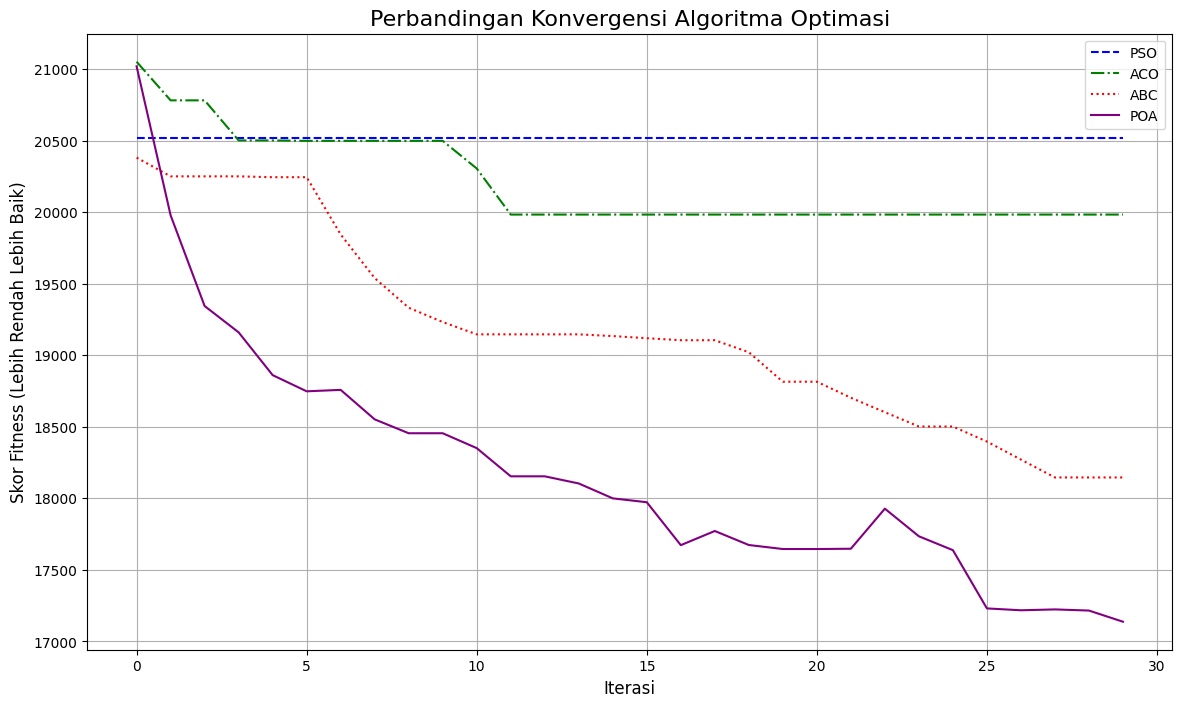


Grafik perbandingan konvergensi disimpan sebagai 'convergence_comparison.png'


In [ ]:
print("\n--- Creating Final Comparison Summary ---")

# Check if all history variables exist and are not empty before plotting/tabulating
histories_exist = 'pso_history' in locals() and 'aco_history' in locals() and \
                  'abc_history' in locals() and 'poa_history' in locals()
histories_valid = all(isinstance(h, list) for h in [pso_history, aco_history, abc_history, poa_history])


if histories_exist and histories_valid:
    with mlflow.start_run(run_name="Summary") as run:
        # Create and display the results table
        results = {
            "Algorithm": ["PSO", "ACO", "ABC", "POA"],
            "Best Fitness Score": [pso_fitness, aco_fitness, abc_fitness, poa_fitness],
            "Hard Constraint Violations": [pso_violations, aco_violations, abc_violations, poa_violations]
        }
        df_results = pd.DataFrame(results)
        print("--- COMPARATIVE RESULTS ---")
        print(df_results.to_string())

        # Save table as artifact
        results_csv_path = "final_results.csv"
        try:
            df_results.to_csv(results_csv_path, index=False)
            mlflow.log_artifact(results_csv_path)
            os.remove(results_csv_path)
        except Exception as e:
            print(f"Error saving or logging results table: {e}")


        # Create and log the comparison plot if histories are not empty
        if all(len(h) > 0 for h in [pso_history, aco_history, abc_history, poa_history]):
            plt.figure(figsize=(14, 8))
            plt.plot(pso_history, label="PSO", color="blue", linestyle='--')
            plt.plot(aco_history, label="ACO", color="green", linestyle='-.')
            plt.plot(abc_history, label="ABC", color="red", linestyle=':')
            plt.plot(poa_history, label="POA", color="purple", linestyle='-')

            plt.title("Comparison of Algorithm Convergence", fontsize=16)
            plt.xlabel("Iteration", fontsize=12)
            plt.ylabel("Best Fitness Score (Lower is Better)", fontsize=12)
            # Add y-axis limits if needed to handle large initial values
            # plt.ylim(bottom=min(min(h) for h in [pso_history, aco_history, abc_history, poa_history] if h)-1000,
            #          top=max(max(h) for h in [pso_history, aco_history, abc_history, poa_history] if h)+1000)
            plt.legend()
            plt.grid(True)

            # Save plot as artifact
            plot_path = "convergence_comparison.png"
            try:
                plt.savefig(plot_path)
                mlflow.log_artifact(plot_path)
                plt.show() # Display the plot in the notebook
                os.remove(plot_path)
            except Exception as e:
                print(f"Error saving or logging convergence plot: {e}")
        else:
             print("Skipping convergence plot generation because one or more history lists are empty.")

    print("\nSummary run logged to MLflow.")
else:
    print("\nSkipping final comparison because results from one or more algorithms are missing or invalid.")